In [2]:
from alpha.notebook import *

await init_notebook()

In [3]:
async def scan(end, frame_type:FrameType=FrameType.DAY):
    results = []
    n = 40 if frame_type == FrameType.MIN30 else 10
    end = tf.floor(arrow.get(end), frame_type)
    start = tf.shift(end, -n, frame_type)
    for code in Securities().choose(["stock"]):
        sec = Security(code)

        try:
            bars = await sec.load_bars(start, end, frame_type)
            if len(bars) <n or np.count_nonzero(np.isfinite(bars["close"])) < 0.9 < len(bars):
                continue

            vf = top_volume_direction(bars, n= n)

            if frame_type != FrameType.DAY:
                day_end = end.date()
                day_start = tf.day_shift(day_end, -1)
                
                # 涨跌幅总是使用日线来计算
                day_bars = await sec.load_bars(day_start, day_end, FrameType.DAY)
                c1, c0 = day_bars["close"][-2:]
            else:
                c1, c0 = bars["close"][-2:]
                
        except Exception:
            continue
            
        row = [sec.display_name, code, c0/c1-1]
        row.extend(vf)

        results.append(row)

    df = pd.DataFrame(results, columns=["name", "code", "adv", "vf1", "vf2", "vf3"])
    df["vsum"] = df.vf1 + df.vf2 + df.vf3
    
    return df

In [4]:
def query(df, adv=0.1, vsum=6, up_ratio = 10, down_ratio = -3):
    df_ = df
    df_ = df_[df_.vsum>vsum]
    df_ = df_[(df_.vf1 > down_ratio) & (df_.vf2 > down_ratio) & (df_.vf3 > down_ratio)]
    df_ = df_[(df_.vf1 > up_ratio) | (df_.vf2 > up_ratio) | (df_.vf3 > up_ratio)]
    df_ = df_[df_.adv < adv]
    df_ = df_.sort_values("adv")
    
    df_["adv"] = df_.adv.apply(lambda x: f"{x:.1%}")
    return df_

In [5]:
df = await scan("2021-09-24 15:00", FrameType.MIN30)

In [17]:
qry = query(df,vsum=10,up_ratio=8, down_ratio=0)
qry

,name,code,adv,vf1,vf2,vf3,vsum
1935,熙菱信息,300588.XSHE,-1.5%,2.279816,2.662777,8.228097,13.170690
434,招商蛇口,001979.XSHE,-0.7%,3.220472,3.811186,8.671637,15.703295
3692,天域生态,603717.XSHG,-0.2%,9.295072,2.792335,2.365276,14.452683
3280,三峰环境,601827.XSHG,4.7%,5.379282,3.704259,8.949782,18.033322
1302,西麦食品,002956.XSHE,5.2%,2.545421,2.995453,9.056903,14.597778
3694,良品铺子,603719.XSHG,10.0%,3.870896,8.746306,3.086009,15.703211


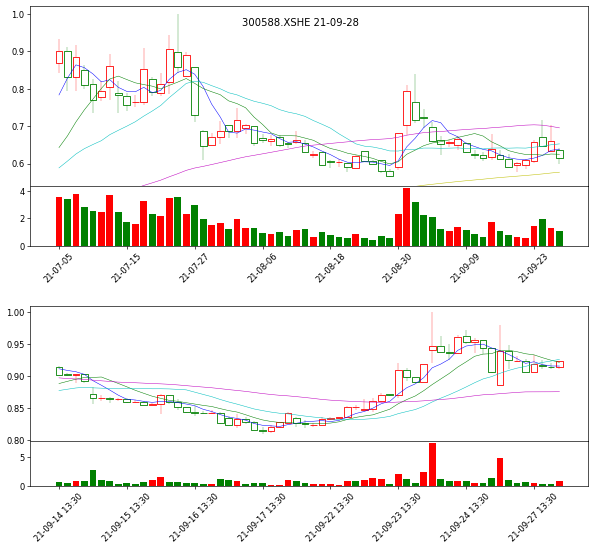

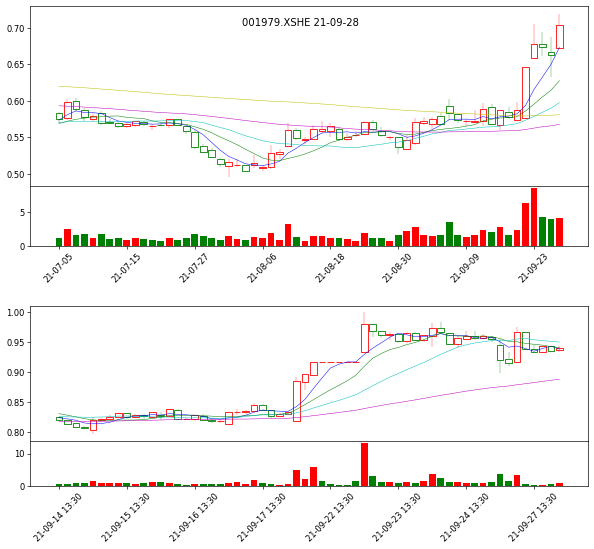

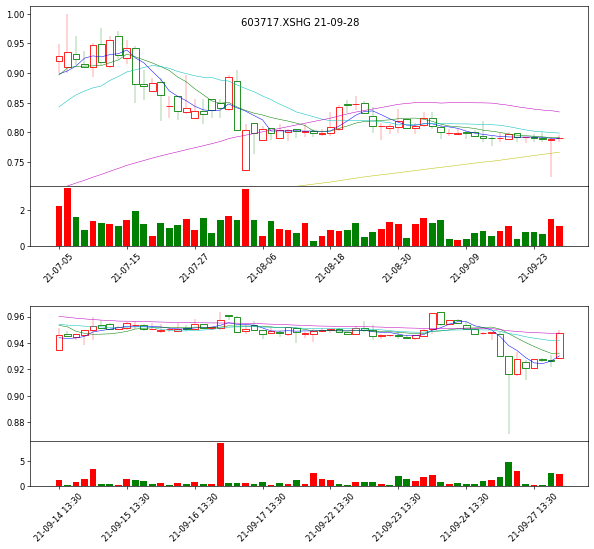

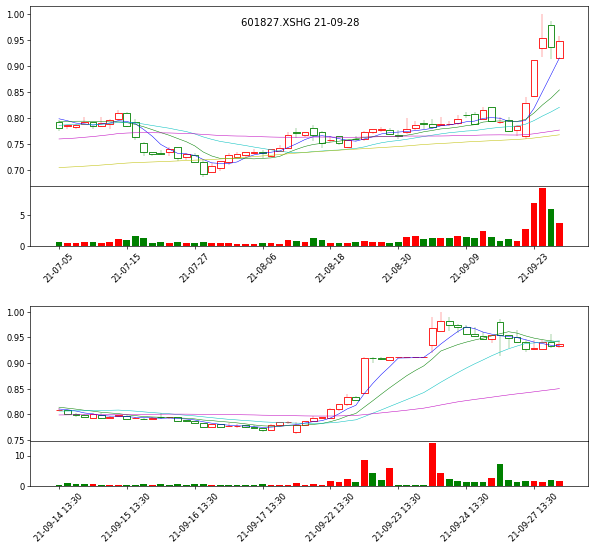

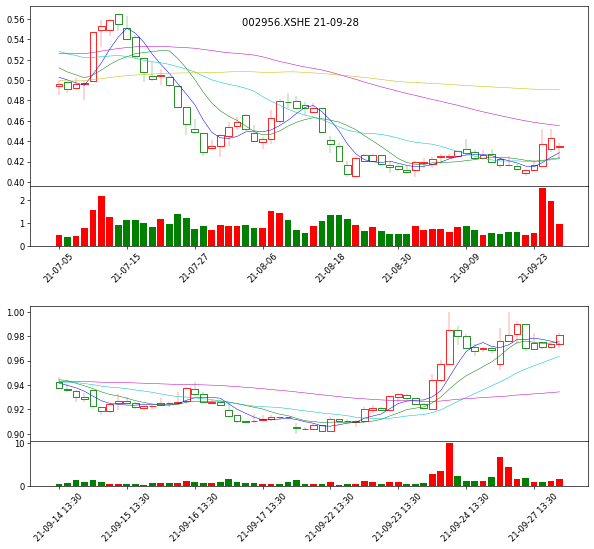

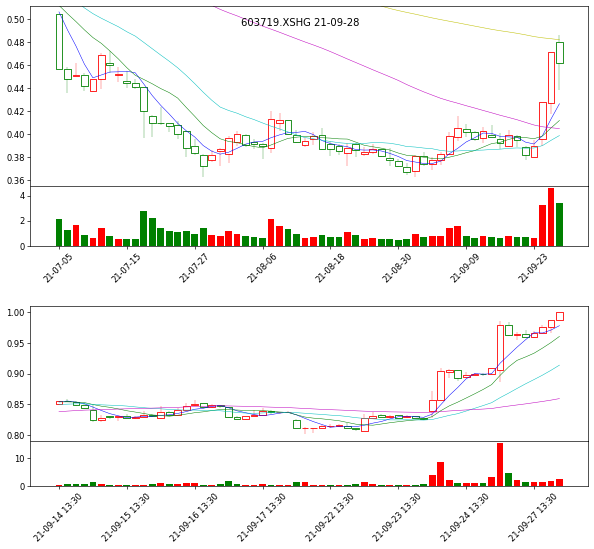

In [18]:
frame = arrow.get("2021-09-28")

for row in qry.to_records():
    code = row["code"]
    
    cs = Candlestick()
    await cs.plot(code, frame)

In [ ]:
#### start = arrow.get("2021-09-22")
end = arrow.get("2021-09-23")
bars = await Security("600699.XSHG").load_bars(start, end, FrameType.DAY)
bars

# 快速扫描

In [25]:
import os
import jqdatasdk as jq

def ten_hour_scan(vcr_threshold=5):
    account = os.getenv("JQ_ACCOUNT")
    password = os.getenv("JQ_PASSWORD")

    jq.auth(account, password)

    all_codes = Securities().choose(["stock"], exclude_688=True)
    n = len(all_codes) // 100 + 1
    batches = np.array_split(all_codes, n)

    fields = ["date", "open", "high", "low", "close", "volume"]

    end_tm = arrow.now().datetime

    results = []
    
    for codes in batches:
        data = jq.get_bars(codes.tolist(), 11, unit="30m", fields=fields, include_now=True, 
                           df=False, end_dt=end_tm, fq_ref_date=end_tm)
        for code, bars in data.items():
            try:
                # find the max volume bar
                vol = bars["volume"]
                i = np.argmax(vol)
                if bars[i]["date"].hour != 10:
                    continue

                close = bars["close"]
                open_ = bars["open"]
                if close[i] < open_[i] or close[i] < close[i-1]:
                    # 收阴线或者下跌
                    continue

                vcr = vol[i] / np.min(vol[:i])
                if vcr < vcr_threshold:
                    continue
                name = Security(code).display_name
                print(code, name, vcr)
                results.append((code, name, vcr))
            except Exception as e:
                print(e)
        
    jq.logout()
    return results